# 5. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## 1. 데이터 탐색

In [2]:
from os.path import join


train_data_path = join("data/", "train.csv")
sub_data_path = join("data/", "test.csv")

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print("train data dim : {}".format(train.shape))
print("sub data dim : {}".format(sub.shape))
train.head()


train data dim : (15035, 21)
sub data dim : (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


훈련 데이터와 테스트 데이터의 비율은 약 `15000:6500`으로 합이 100이 되도록 표현하면 약 `70:30`입니다.  
데이터에 존재하는 변수의 갯수는 20개입니다.  

### 데이터 항목
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### price 확인
모델을 통해 예측하고자 하는 `price`의 분포를 확인합니다.

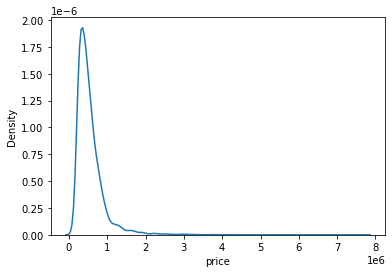

In [3]:
sns.kdeplot(train["price"])
plt.show()


정규분포를 따르지 않고 왼쪽에 데이터가 집중적으로 분포되어 있습니다. 정규분포에 가까워지도록 log-scaling을 적용합니다.

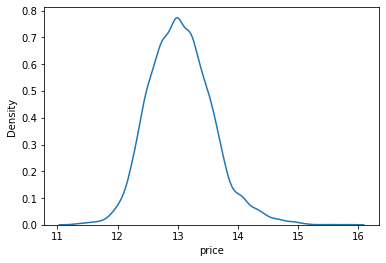

In [4]:
train["price"] = np.log1p(train["price"])
sns.kdeplot(train["price"])
plt.show()


정규분포와 유사한 형태로 바뀌었습니다.

### 상관 계수 확인
`price`와 다른 변수들과의 상관관계를 파악하고자 `Spearman's rank correlation coefficient`를 확인하였습니다.
- `Pearson Correlation Coefficient`는 두 변수 간의 선형 상관 관계를 수치로 나타는 것으로 continuous 데이터에 적용합니다.
- `Spearman's rank correlation coefficient`는 continuous 데이터 뿐만 아니라, discrete 데이터에도 적용이 가능합니다.

`price`와 coefficient가 높은 순서대로 정렬하여 출력합니다.

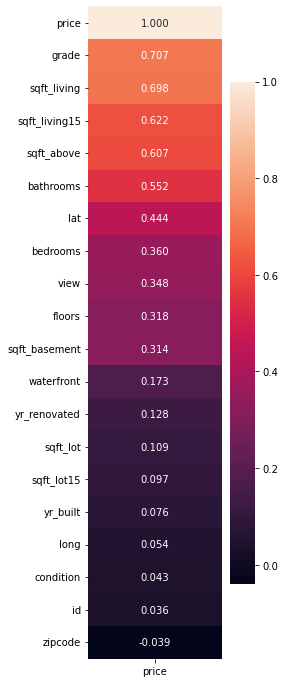

In [5]:
corr_df = train.corr(method="pearson")
idx = corr_df.sort_values("price", ascending=False).index
corr_df = corr_df.loc[idx, :][["price"]]
plt.figure(figsize=(3, 12))
sns.heatmap(corr_df, annot=True, fmt=".3f")
plt.show()


- 집의 등급, 주거공간의 넓이, 그리고 2015년 기준 주거공간의 넓이의 상관계수가 높습니다.
- 데이터 식별을 위한 `id`는 상관계수가 낮습니다.
- 우편번호인 `zipcode`는 상관계수가 낮습니다.
- `condition`, `long`, `yr_built`, `sqft_lot15`, `sqft_lot`, `yr_renovated`은 다른 변수에 비해 `price`와 상관관계가 작은 것으로 판단됩니다.

### 가격과 변수의 관계
변수들과 가격과의 관계를 그래프로 표현하고 특이사항을 확인합니다.  

#### 상관 관계가 높은 변수
가격과 상관계수가 높은 변수들을 그래프로 표현해 특성을 확인하겠습니다.
- `grade`, `sqft_living`, `sqft_living15`

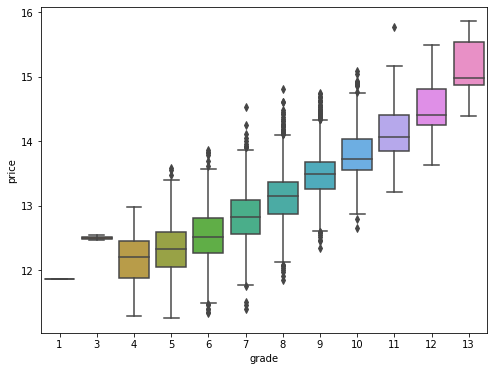

In [6]:
comparison = pd.concat([train["price"], train["grade"]], axis=1)
plt.figure(figsize=(8, 6))
sns.boxplot(x="grade", y="price", data=comparison)
plt.show()


등급이 높아질수록 가격도 상승하는 경향을 확인할 수 있습니다.  
등급이 6에서 10사이인 경우 이상치가 많습니다.

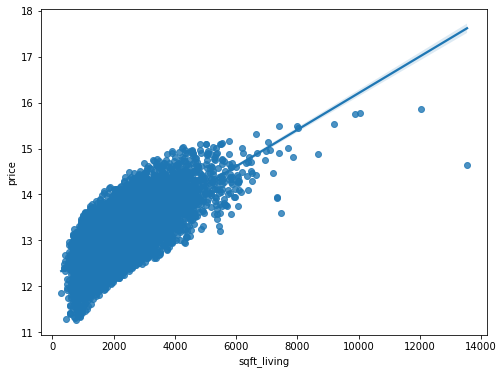

In [7]:
comparison = pd.concat([train["price"], train["sqft_living"]], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x="sqft_living", y="price", data=comparison)
plt.show()


주거 공간의 경우 비슷한 가격이라면 면적이 비슷하고, 비슷한 면적이라면 가격이 일정 범위 내에서 존재합니다.  
다만 비슷한 가격에서 면적이 매우 큰 경우가 존재하여 이상치로 판단, 처리 여부를 결정하여야 합니다.

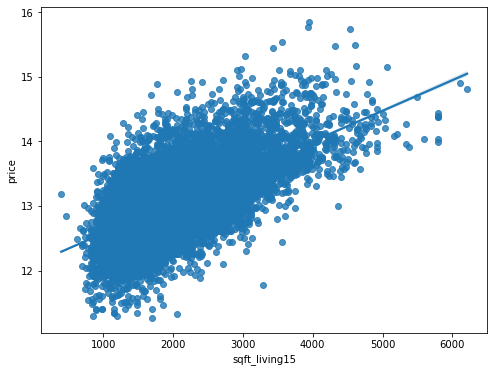

In [8]:
comparison = pd.concat([train["price"], train["sqft_living15"]], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x="sqft_living15", y="price", data=comparison)
plt.show()


2015년 기준 주거 공간은 면적이 증가하면 가격이 증가하는 관계를 보이지만, 값의 분산이 상대적으로 큽니다.

#### 상관계수가 낮은 변수
가격과 상관계수가 낮은 변수들 또한 그래프로 표현하여 특성을 확인하겠습니다.
- `condition`, `long`, `yr_built`

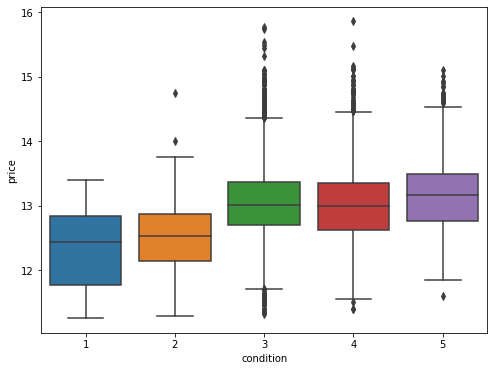

In [9]:
comparison = pd.concat([train["price"], train["condition"]], axis=1)
plt.figure(figsize=(8, 6))
sns.boxplot(x="condition", y="price", data=comparison)
plt.show()


집의 상태의 경우 측정 기준이 규정되어 있지 않거나, 주관적인 판단이 많이 반영되어 있는지 가격과의 상관 관계가 낮은 것으로 보입니다.

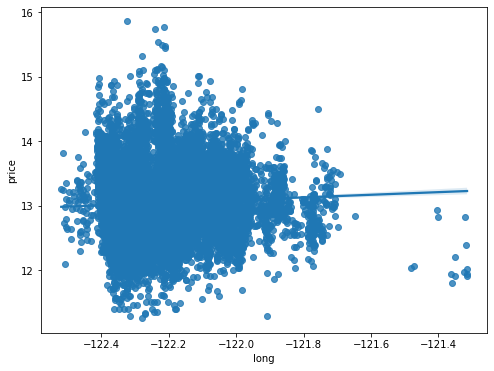

In [10]:
comparison = pd.concat([train["price"], train["long"]], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x="long", y="price", data=comparison)
plt.show()


경도의 경우 증가 혹은 감소함에 따라 가격이 변동된다고 판단하기 힘들며, 비슷한 경도에서도 가격의 분포가 매우 넓습니다.  
위치를 나타내기 위해서는 위도와 경도가 필요하기 때문에, 경도만을 보고 가격을 추정하기에는 어렵다고 판단됩니다.

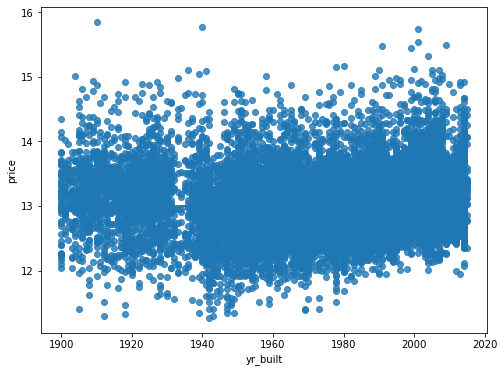

In [11]:
comparison = pd.concat([train["price"], train["yr_built"]], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x="yr_built", y="price", data=comparison)
plt.show()


건물이 지어진 연도가 변화하면서 가격이 어떤 추세로 변한다고 판단하기 어렵습니다.

### 위치
위도와 경도 정보를 이용하여 지도 상에서 데이터를 표현하고 특성을 확인합니다.

지도 상에서의 시각화는 [folium](https://github.com/python-visualization/folium) 라이브러리를 사용하였습니다.  
데이터가 가지고 있는 위도와 경도의 평균값을 중앙으로 하여 지도를 출력합니다.

In [12]:
import folium


l1 = train["lat"].mean()
l2 = train["long"].mean()

# print(l1, l2)
m = folium.Map(location=[l1, l2], min_zoom=9)
m


데이터는 시애틀을 중심으로 위치해있는 집들의 가격임을 알 수 있습니다.

집 가격의 상위 25%와 하위 25%는 어디에 위치해 있는지 확인합니다.
(좌: 하위 25%, 우: 상위 25%)

In [13]:
from folium.plugins import HeatMap, DualMap


n_q1 = train["price"].quantile(0.25)
n_q4 = train["price"].quantile(0.75)
q1 = train[train["price"] < n_q1]
q4 = train[train["price"] > n_q4]
heat1 = HeatMap(pd.concat([q1["lat"], q1["long"], q1["price"]], axis=1))
heat4 = HeatMap(pd.concat([q4["lat"], q4["long"], q4["price"]], axis=1))

m = DualMap(location=[l1, l2], min_zoom=9)
heat1.add_to(m.m1)
heat4.add_to(m.m2)
folium.Marker(location=[q1["lat"].mean(), q1["long"].mean()]).add_to(m.m1)
folium.Marker(location=[q4["lat"].mean(), q4["long"].mean()]).add_to(m.m2)
m


집 가격의 하위 25%는 주로 남쪽에, 상위 25%는 주로 북쪽에 위치해 있습니다.  
조금 더 구분해서 생각하면 하위 25%는 남서쪽에, 상위 25%는 주로 북동쪽에 위치해 있습니다.  
`long` 또는 `lat` 변수가 각각 독립적으로 `price`에 영향을 준다고 보기 어렵습니다.

In [14]:
m = DualMap(location=[l1, l2], min_zoom=9)
heat1.add_to(m.m1)
heat4.add_to(m.m2)
folium.Marker(
    location=[q1["lat"].mean(), q1["long"].mean()], popup="center of Bottom Quater"
).add_to(m.m1)
folium.Marker(
    location=[q4["lat"].mean(), q4["long"].mean()], popup="center of Top Quater"
).add_to(m.m2)
folium.CircleMarker(
    location=[q1["lat"].mean(), q1["long"].mean()], radius=100, fill_color="#fffggg",
).add_to(m.m1)
folium.CircleMarker(
    location=[q4["lat"].mean(), q4["long"].mean()], radius=100, fill_color="#fffggg",
).add_to(m.m2)
m


집값 상위 25% 데이터들의 좌표값의 평균으로 구한 중앙에서 일정 범위 내에 데이터들이 분포하고 있습니다.  
하지만 이 영역을 벗어나는 영역도 존재하며 영역의 크기가 커진다면 하위 25%의 데이터가 포함되는 경우도 발생할 수 있기에 이 지점들과의 거리를 변수로 사용하기는 어려워 보입니다.

이번에는 조금 더 가까이서 살펴보겠습니다.(University of Washington 중심)  

In [15]:
m = DualMap(location=[47.655548, -122.303200], min_zoom=12)
folium.Marker(
    location=[47.655548, -122.303200], popup="University of Washington"
).add_to(m)
folium.Marker(location=[47.708333, -122.328333], popup="Northgate").add_to(m)
folium.Marker(location=[47.7191619, -122.2954939], popup="Lake City").add_to(m)
heat1.add_to(m.m1)
heat4.add_to(m.m2)
m


- 전체적으로 보았을 때 상위 25%의 집은 북쪽에 많이 분포해있지만, Northgate와 Lake City 지역보다 더 북쪽에 위치한다면 하위 25%의 집일 확률이 높습니다.  
단순히 북쪽에 위치한다는 이유로 집값이 높다고 말할 수 없습니다.  
- 위도나 경도의 절대적인 값보다는 "어느 Town에 속하는가" 또는 "어느 Street에 가까운가"가 가격을 결정하는 요소라 생각됩니다.  
따라서 `zipcode`에 대한 분석이 필요합니다.


### `zipcode` 분석


In [16]:
print(sorted(train["zipcode"].unique()))
print(len(train["zipcode"].unique()))


[98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]
70


변수는 70개의 고유한 값을 가지고 있습니다.  
`zipcode`에 따라 집값의 평균이 변하는가를 확인하기 위해 "주거 공간 면적 당 가격"을 기준으로 그래프를 작성하였습니다.  

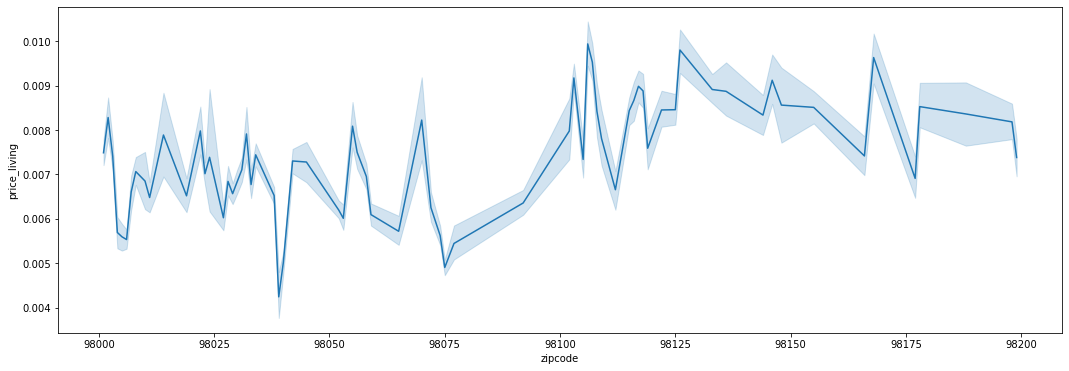

In [17]:
temp = train.copy()
temp["price_living"] = train["price"] / train["sqft_living"]
comparison = pd.concat([temp["zipcode"], temp["price_living"]], axis=1)
plt.figure(figsize=(18, 6))
sns.lineplot(x="zipcode", y="price_living", data=comparison)
plt.show()


`zipcode`에 따라 면적 당 가격에 차이가 있음을 확인할 수 있습니다.

### 분포
데이터의 분포가 정규분포와 다르게 한쪽으로 치우친 상태라면 회귀 모델의 훈련에 좋지 않기 때문에 변수들의 분포를 확인합니다.

In [18]:
train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


`id`, `date`, `price`를 제외한 나머지 변수들의 분포를 확인합니다.

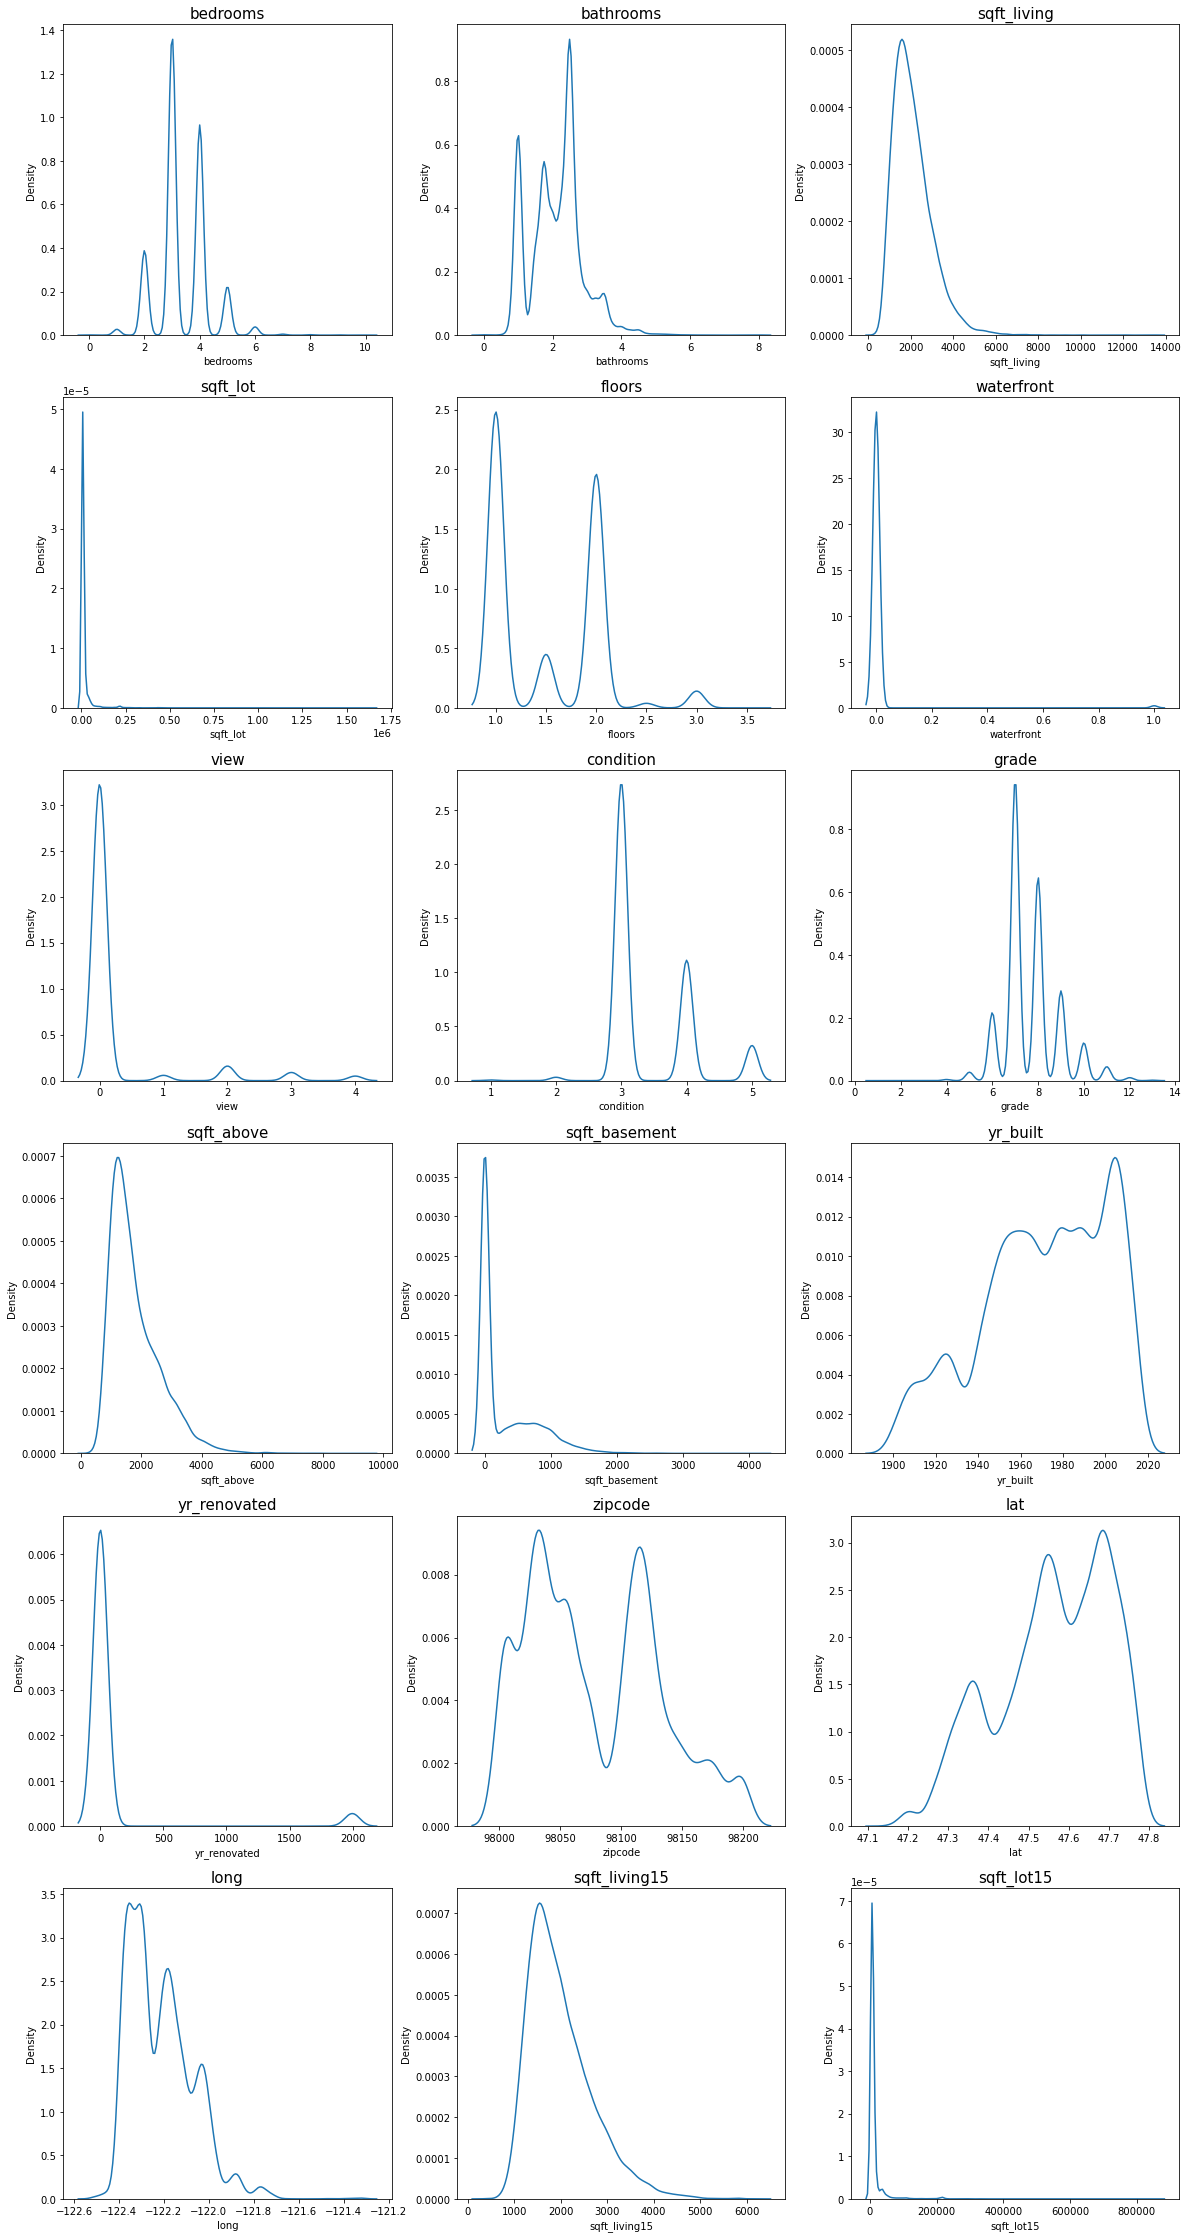

In [19]:
fig, ax = plt.subplots(6, 3, figsize=(20, 40))

count = 3
columns = train.columns
for row in range(6):
    for col in range(3):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1


`sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_living15`, `sqft_lot15`은 분포가 한쪽으로 크게 치우쳐져 있습니다.  
이후 전처리 과정에서 정규분포에 가깝도록 가공할 필요가 있습니다.

## 2. 전처리 
데이터 확인 과정에서 발견한 문제들을 위한 전처리와 결측치에 대한 처리를 진행합니다.

### 이상치 제거

In [20]:
train.sort_values(by=["sqft_living"], ascending=False).head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.00,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
5108,5108,20141013T000000,15.856731,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
2775,2775,20140611T000000,15.770310,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
6469,6469,20140919T000000,15.744856,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
3134,3134,20140804T000000,15.532906,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345


`id`가 8912인 데이터는 비슷한 가격대의 다른 집과 비교하여 매우 큰 `sqft_living`과 `sqft_lot`을 가지고 있습니다.  
해당 데이터는 이상치로 제거합니다.

In [21]:
train = train.loc[train["id"] != 8912]


### `zipcode` 기반 변수 추가
데이터 탐색 과정에서 `zipcode` 기반 데이터의 필요성을 확인하였고 전처리 과정에서 적용하고자 합니다.  
동일한 `zipcode`를 가지고 있는 데이터들의 주거 면적 당 가격을 계산하고, 이를 데이터에 추가합니다.

In [22]:
temp = train.copy()
temp["price_living"] = temp["price"] / temp["sqft_living"]
temp_group = temp.groupby(["zipcode"])["price_living"].mean().reset_index()
temp_group.rename(columns={"price_living": "zip_price"}, inplace=True)
print(temp_group.head())

train = pd.merge(train, temp_group, on="zipcode", how="left")
sub = pd.merge(sub, temp_group, on="zipcode", how="left")
train.head()
# sub.head()


   zipcode  zip_price
0    98001   0.007487
1    98002   0.008281
2    98003   0.007408
3    98004   0.005692
4    98005   0.005595


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zip_price
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0.008527
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0.006842
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0.005623
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,0.007408
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,0.008183


### 훈련 데이터 + 테스트 데이터
전체 데이터에 대해 전처리를 적용하기 위해 훈련 데이터와 테스트 데이터를 병합합니다.  
우선, 훈련 데이터는 가격 데이터를 포함하고 있어 `price` column을 별도 변수 `y`에 저장합니다.  
이후 훈련 데이터와 테스트 데이터를 이어줍니다.

In [23]:
y = train["price"]
del train["price"]

train_len = len(train)
data = pd.concat((train, sub), axis=0)
# print(len(train))
# data.head()


### 변수 가공
- `date` 변수을 연,월,일로 분리하고 `year`, `month`, 그리고 `weekday`을 변수로 사용합니다.
  - `date` 변수는 더 이상 필요하지 않아 제거합니다.
- `yr_renovated`만으로는 재건축 여부를 나타내기에 부족하다고 판단하여, 재건축 여부를 0 또는 1로 나타내는 변수 `is_renovated`를 추가합니다.
- 집값 예측에 필요하지 않은 `id` 변수를 제거합니다.  
- `zipcode`는 해당 정보를 이용하여 다른 변수를 생성하였기에 더 이상 필요하지 않아 제거합니다.

In [24]:
from datetime import datetime


data["year"] = data["date"].apply(lambda x: x[:4]).astype("int64")
data["month"] = data["date"].apply(lambda x: x[4:6]).astype("int64")
data["weekday"] = (
    data["date"]
    .apply(lambda x: datetime.strptime(x[:8], "%Y%M%d").weekday())
    .astype("int64")
)
# data["day"] = data["date"].apply(lambda x: x[6:8]).astype("int64")

data["is_renovated"] = data["yr_renovated"]
data["is_renovated"] = data["is_renovated"].apply(lambda x: 0 if x == 0 else 1)

sub_id = data["id"][train_len:]

data = data.drop(columns=["id", "zipcode", "date"])

data.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,lat,long,sqft_living15,sqft_lot15,zip_price,year,month,weekday,is_renovated
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,47.5112,-122.257,1340,5650,0.008527,2014,10,0,0
1,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,47.7379,-122.233,2720,8062,0.006842,2015,2,6,0
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,47.6168,-122.045,1800,7503,0.005623,2015,2,6,0
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,...,0,47.3097,-122.327,2238,6819,0.007408,2014,6,0,0
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,...,0,47.4095,-122.315,1650,9711,0.008183,2015,1,3,0


### 결측치 확인
각 column에 대해 결측치가 존재하는지 확인합니다.

In [25]:
for c in data.columns:
    print(f"{c} : {len(data.loc[pd.isnull(data[c]), c].values)}")


bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
zip_price : 0
year : 0
month : 0
weekday : 0
is_renovated : 0


결측치가 존재하지 않아 별도의 처리는 필요하지 않습니다.

### 분포 변화
데이터 탐색 과정에서 `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_lot15`, `sqft_living15` 변수 분포가 정규분포와 크게 다름을 확인하였습니다.  
log-scaling을 통해 정규분포와 유사해질 수 있는지 확인합니다.

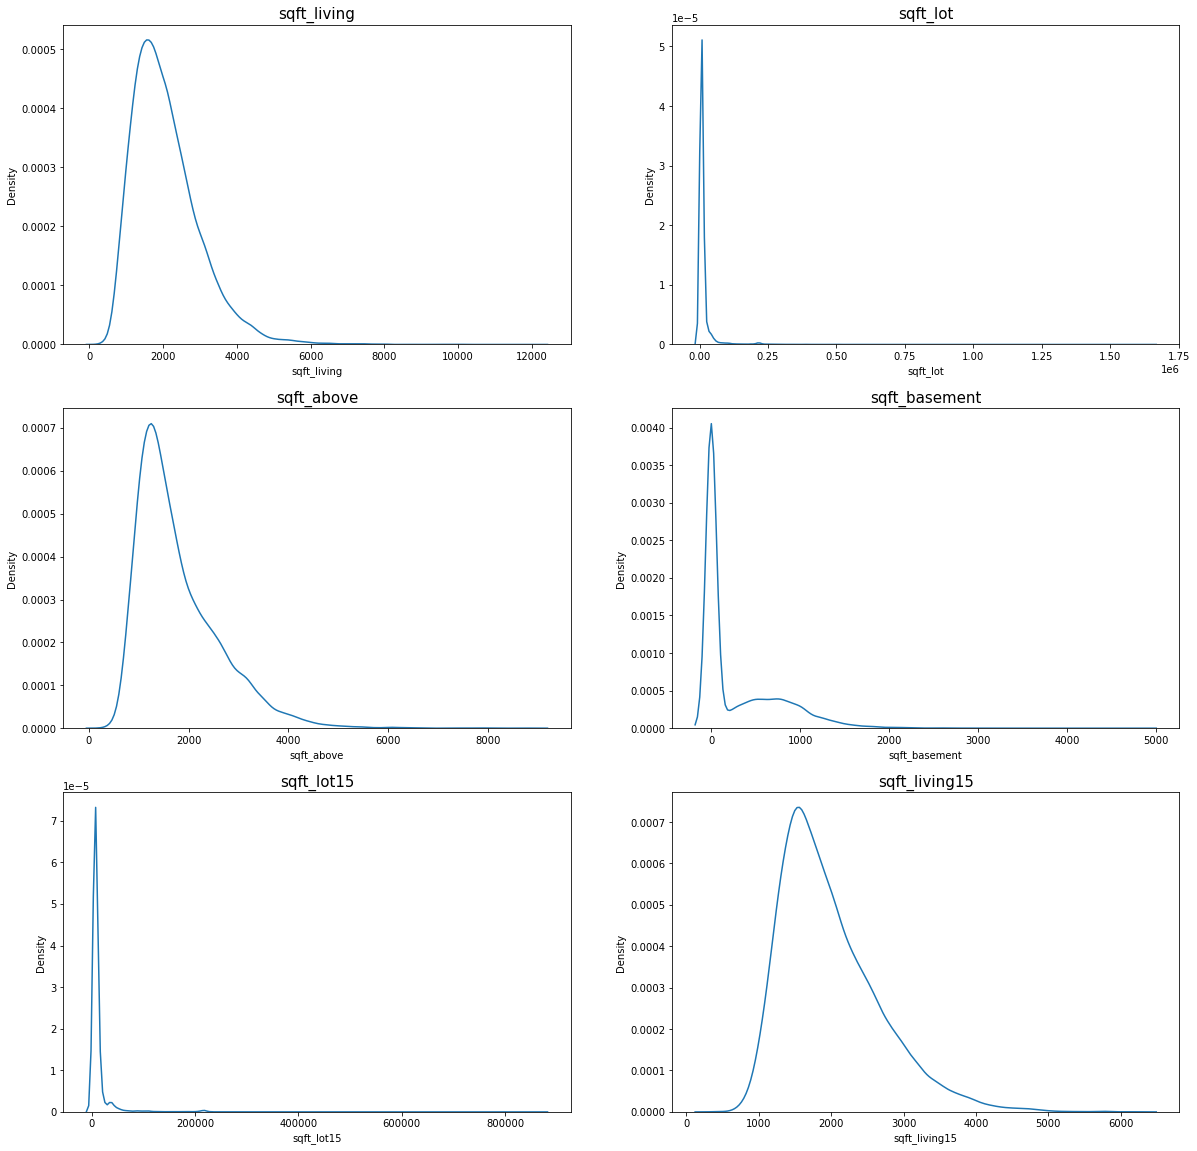

In [26]:
skew_columns = [
    "sqft_living",
    "sqft_lot",
    "sqft_above",
    "sqft_basement",
    "sqft_lot15",
    "sqft_living15",
]

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1


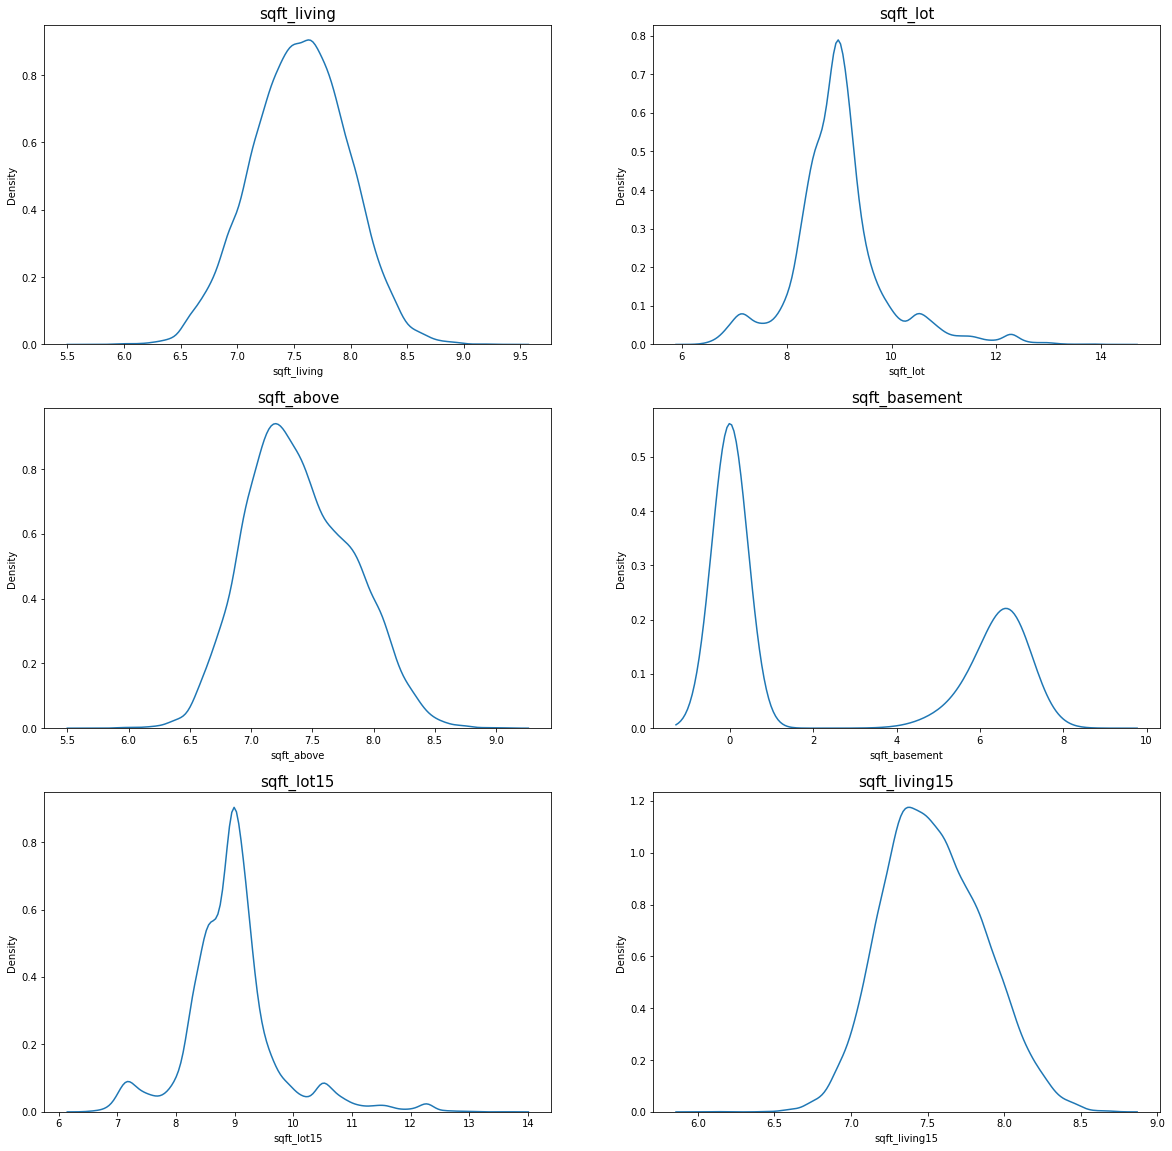

In [27]:
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1


어느정도 치우침이 줄어들어 정규분포에 가까운 모습을 확인할 수 있습니다.

### 훈련 데이터와 테스트 데이터 분리

In [28]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(sub.shape)
print(x.shape)
x.info()



(6468, 22)
(15034, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15034 entries, 0 to 15033
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15034 non-null  int64  
 1   bathrooms      15034 non-null  float64
 2   sqft_living    15034 non-null  float64
 3   sqft_lot       15034 non-null  float64
 4   floors         15034 non-null  float64
 5   waterfront     15034 non-null  int64  
 6   view           15034 non-null  int64  
 7   condition      15034 non-null  int64  
 8   grade          15034 non-null  int64  
 9   sqft_above     15034 non-null  float64
 10  sqft_basement  15034 non-null  float64
 11  yr_built       15034 non-null  int64  
 12  yr_renovated   15034 non-null  int64  
 13  lat            15034 non-null  float64
 14  long           15034 non-null  float64
 15  sqft_living15  15034 non-null  float64
 16  sqft_lot15     15034 non-null  float64
 17  zip_price      15034 non-nu

훈련 데이터 15034개, 테스트 데이터 6468개로 분리가 되었습니다.

## 3. 모델링

### 모델 준비


하이퍼파라미터 튜닝을 하지 않고 기본값을 사용한 모델들의 성능을 확인합니다.

In [29]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import cross_validate


SEED = 78
CV = 5

rdforest = RandomForestRegressor(random_state=SEED)
gboost = GradientBoostingRegressor(random_state=SEED)
xgboost = xgb.XGBRegressor(random_state=SEED)
lightgbm = lgb.LGBMRegressor(random_state=SEED)
cboost = cb.CatBoostRegressor(random_state=SEED, verbose=0)


models = [rdforest, gboost, xgboost, lightgbm, cboost]


def get_scores(models, x, y):
    df = {}
    for model in models:
        name_model = model.__class__.__name__
        results = cross_validate(
            model, x.values, y, scoring="neg_mean_squared_error", cv=CV
        )
        score = results["test_score"].mean()
        df[name_model] = np.sqrt(-1 * score)
        score_df = pd.DataFrame(df, index=["RMSLE"]).T.sort_values(
            "RMSLE", ascending=False
        )
    return score_df


get_scores(models, x, y)


,RMSLE
GradientBoostingRegressor,0.180426
RandomForestRegressor,0.178699
XGBRegressor,0.169962
LGBMRegressor,0.164717
CatBoostRegressor,0.157928


Grid Search를 통하여 각 모델의 최적의 파라미터를 탐색할 수 있습니다.

In [30]:
from sklearn.model_selection import GridSearchCV


rdforest = RandomForestRegressor(random_state=SEED)
gboost = GradientBoostingRegressor(random_state=SEED)
xgboost = xgb.XGBRegressor(random_state=SEED)
lightgbm = lgb.LGBMRegressor(random_state=SEED)
cboost = cb.CatBoostRegressor(random_state=SEED, verbose=0)


models = [rdforest, gboost, xgboost, lightgbm, cboost]

param_grids = {
    "RandomForestRegressor": {"n_estimators": [100, 200, 1000]},
    "GradientBoostingRegressor": {"n_estimators": [100, 1000], "max_depth": [3, 6]},
    "LGBMRegressor": {
        "n_estimators": [100, 200, 1000],
        "learning_rate": [0.1, 0.05, 0.01],
        "num_leaves": [15, 31, 63],
        "feature_fraction": [0.8, 0.9, 1.0],
        "lambda_l1": [0.0, 0.1, 0.2],
    },
    "XGBRegressor": {
        "eta": [0.3, 0.1, 0.01],
        "n_estimators": [100, 200, 1000],
        "max_depth": [3, 6],
        "subsample": [0.5, 0.8, 1.0],
    },
    "CatBoostRegressor": {
        "iterations": [100, 200, 1000],
        "learning_rate": [0.1, 0.05, 0.01],
    },
}


def my_gridsearch(m, x, y):
    gri = GridSearchCV(
        m,
        param_grid=param_grids[m.__class__.__name__],
        scoring="neg_mean_squared_error",
        cv=CV,
        n_jobs=4,
    )
    gri.fit(x.values, y)

    params = gri.cv_results_["params"]
    score = gri.cv_results_["mean_test_score"]
    results = pd.DataFrame(params)
    results["score"] = score
    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results = results.sort_values(by=["RMSLE"])
    print(m.__class__.__name__, gri.best_params_)
    return gri.best_estimator_, results["RMSLE"][0]


best_models = []
for m in models:
    best_models.append(my_gridsearch(m, x, y))

best_models = sorted(best_models, key=lambda x: x[1])
top_models_g = [m for m, __ in best_models[:3]]
pd.DataFrame({(m.__class__.__name__, s) for (m, s) in best_models}).sort_values(
    1, ascending=False
)


RandomForestRegressor {'n_estimators': 1000}
GradientBoostingRegressor {'max_depth': 3, 'n_estimators': 1000}
XGBRegressor {'eta': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
LGBMRegressor {'feature_fraction': 0.8, 'lambda_l1': 0.2, 'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 15}
CatBoostRegressor {'iterations': 1000, 'learning_rate': 0.1}


,0,1
1,GradientBoostingRegressor,0.180426
3,RandomForestRegressor,0.178699
4,XGBRegressor,0.175039
2,CatBoostRegressor,0.171641
0,LGBMRegressor,0.168114


Bayesian Optimization을 사용하여 최적의 파라미터를 탐색합니다.([scikit-optimize](https://scikit-optimize.github.io/stable/))

In [31]:
from skopt import BayesSearchCV


rdforest = RandomForestRegressor(random_state=SEED)
gboost = GradientBoostingRegressor(random_state=SEED)
xgboost = xgb.XGBRegressor(random_state=SEED)
lightgbm = lgb.LGBMRegressor(random_state=SEED)
cboost = cb.CatBoostRegressor(random_state=SEED, verbose=0)


models = [rdforest, gboost, xgboost, lightgbm, cboost]

search_spaces = {
    "RandomForestRegressor": {"n_estimators": (50, 2000), "max_depth": (3, 9)},
    "GradientBoostingRegressor": {
        "learning_rate": (1e-2, 1e-1),
        "n_estimators": (50, 2000),
        "max_depth": (3, 9),
    },
    "LGBMRegressor": {
        "num_leaves": (15, 63),
        "learning_rate": (1e-2, 2e-1),
        "n_estimators": (50, 2000),
        "feature_fraction": (0.8, 1.0),
        "lambda_l1": (0.0, 0.2),
    },
    "XGBRegressor": {
        "learning_rate": (1e-2, 3e-1),
        "n_estimators": (50, 2000),
        "max_depth": (3, 9),
        "subsample": (0.5, 1.0),
    },
    "CatBoostRegressor": {"iterations": (50, 2000), "learning_rate": (1e-2, 2e-1)},
}


def my_bayes(m, x, y):
    opt = BayesSearchCV(
        m,
        search_spaces[m.__class__.__name__],
        n_iter=16,
        n_jobs=4,
        cv=CV,
        scoring="neg_mean_squared_error",
    )
    opt.fit(x.values, y)

    params = opt.cv_results_["params"]
    score = opt.cv_results_["mean_test_score"]
    results = pd.DataFrame(params)
    results["score"] = score
    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results = results.sort_values(by=["RMSLE"])
    print(m.__class__.__name__, dict(opt.best_params_))
    return opt.best_estimator_, results["RMSLE"][0]


best_models = []
for m in models:
    best_models.append(my_bayes(m, x, y))

best_models = sorted(best_models, key=lambda x: x[1])
top_models_b = [m for m, __ in best_models[:2]]
pd.DataFrame({(m.__class__.__name__, s) for (m, s) in best_models}).sort_values(
    1, ascending=False
)


C:\Users\jhoon\miniconda3\envs\aiffel\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestRegressor {'max_depth': 9, 'n_estimators': 2000}
GradientBoostingRegressor {'learning_rate': 0.03984897215835088, 'max_depth': 4, 'n_estimators': 1506}
XGBRegressor {'learning_rate': 0.020797318480844262, 'max_depth': 6, 'n_estimators': 1543, 'subsample': 0.8579113044575997}
LGBMRegressor {'feature_fraction': 0.8129628618113042, 'lambda_l1': 0.08661690303181346, 'learning_rate': 0.020695767687374446, 'n_estimators': 1450, 'num_leaves': 22}
CatBoostRegressor {'iterations': 1331, 'learning_rate': 0.06957264672081372}


,0,1
2,RandomForestRegressor,0.263712
3,GradientBoostingRegressor,0.175359
0,XGBRegressor,0.172112
1,LGBMRegressor,0.163213
4,CatBoostRegressor,0.159614


오차가 작은 상위 3개를 기준으로, Bayesian Optimization을 이용하여 훈련한 모델들의 오차가 가장 작았습니다.  
따라서 오차가 가장 적은 모델 2개의 예측 결과 평균을 사용합니다.

In [32]:
def average_blending(models, sub_x):
    predictions = []
    for m in models:
        predictions.append(np.expm1(m.predict(sub_x.values)))

    predictions = np.column_stack(predictions)
    return np.mean(predictions, axis=1)


In [33]:
y_pred = average_blending(top_models_b, sub)


In [34]:
sub = pd.DataFrame(data={"id": sub_id, "price": y_pred})
sub.to_csv("submission.csv", index=False)


## 실험결과 정리

| Description | Private Score |
| --- | --- |
| 첫번째 시도 | 114724.27768 |
| 두번째 시도 | 114170.84916 |
| 세번째 시도 | 113739.03419 |
| 네번째 시도 | 110688.76656 |
| 다섯번째 시도 | 110782.61671 |
| 여섯번째 시도 | 110067.17517 |
| 일곱번째 시도 | 111235.94253 |
| 여덟번째 시도 | 110504.58297 |
| 아홉번째 시도 | 111435.71231 |
| 열번째 시도 | 109729.12371 |
| 열한번째 시도 | 108919.11895 |

1. 첫번째 시도
   1. `date` 8자리 -> 6자리
   2. `zipcode`에 따른 주거 면적 당 집값 추가
2. 두번째 시도
   1. `date` 6자리 -> 4자리
   2. 재건축 여부 {0, 1}로 표현
3. 세번째 시도
   1. Grid search 탐색 범위 증가
   2. CatBoostRegressor 추가
4. 네번째 시도
   1. Grid search 탐색 범위 증가
   2. RandomForestRegressor 제외
5. 다섯번째 시도
   1. Grid search 탐색 범위 증가
   2. GradientBoostingRegressor 제외
6. 여섯번째 시도
   1. `date`를 `year`, `month`로 분리
   2. Grid search 탐색 범위 축소
   3. GradientBoostingRegressor, RandomForestRegressor 포함
   4. 성능이 가장 좋은 모델 3개의 결과 평균 사용
7. 일곱번째 시도
   1. Grid search와 Bayesian optimization을 통해 최적화된 하이퍼파라미터를 사용하고 그 결과를 비교
   2. `yr_nenovated`가 '0'인 항목을 `yr_built`로 대체
8. 여덟번째 시도
   1. 상위 모델 2개의 결과 평균 사용
   2. LGBMRegressor의 하이퍼파라미터 탐색 공간에 `num_leaves` 추가
9. 아홉번째 시도
   1.  `weekday` 변수 추가
   2.  재건축 여부 {0, 1}로 표현(`is_renovated`)
   3.  `yr_nenovated`가 '0'인 항목을 `yr_built`로 대체
10. 열번째 시도
    1.  `year`, `month`, `weekday` 추가
    2.  탐색 하이퍼파라미터 추가
    3.  `zipcode`, `date` 제거
11. 열한번쨰 시도
    1.  탐색 하이퍼파라미터 추가

## 루브릭

| 평가문항 | 상세기준 |
| --- | --- |
| 1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가? | 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다 |
| 2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가? | 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다. |
| 3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가? | 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다. |

### 루브릭 자체평가
1. 데이터를 확인하여 처리하고, 모델의 학습을 진행, 예측 결과를 얻고, 결과적으로 캐글에 submission을 수행하였다.
2. 데이터를 확인하고, 모델을 학습하는 과정, 그리고 하이퍼파라미터를 탐색하는 과정이 서술되어 있다.
3. 110000 이하의 Private score(108919)를 얻었다.